In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the decoder model
decoder = load_model('/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/decoder_model.h5')

Mounted at /content/drive/


In [ ]:
import os
import cv2
from sklearn.model_selection import train_test_split

def load_images(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            # Read image
            img = cv2.imread(os.path.join(folder_path, filename))
            # Convert to one channel
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Preform normalization and convert to np array
            img_array = np.array(img) / 255.0
            # Fallten image
            # img_array = img_array.flatten()
            image_list.append(img_array)
    return np.array(image_list)

folder_path = "/content/drive/My Drive/CS542 Spring 2023/DS340/DS340_GroupProject/data/process_images"
x_data = load_images(folder_path)


In [ ]:
import tensorflow as tf
import numpy as np

dataset = tf.data.Dataset.from_tensor_slices(x_data)

# Set the batch size
BATCH_SIZE = 128
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import load_model, Sequential
# from tensorflow.keras.layers import InputLayer, Lambda, Dense, Flatten


# LATENT_DIM = 256
# NOISE_DIM = 100
# IMAGE_SIZE = 128

# def sampling(args):
#     z_mean, z_log_var = args
#     batch_size = tf.shape(z_mean)[0]
#     epsilon = tf.keras.backend.random_normal(shape=(batch_size, LATENT_DIM))
#     return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# def generator(decoder, noise_dim=NOISE_DIM):
#     """
#     Generate image from noise 
#     Inputs:
#     - decoder: pretrain model for genrate image freom mean and std
#     - noise_dim: the dimension of the noise 
    
#     Returns:
#     TensorFlow Tensor with shape [number of image in one batch, 49152 = 128 * 128 * 3], we can reshape 49152 after
#     """

#     # Freeze layers in the saved model
#     for i, layer in enumerate(decoder.layers):
#         layer.trainable = False
#         layer._name = f'saved_model_{i}_{layer.name}'

#     model = Sequential([
#         InputLayer(input_shape=(noise_dim,)),
#         Dense(16, activation='relu'),
#         Dense(64, activation='relu'),
#         Dense(128, activation='relu'),
#         Dense(256, activation='relu'),
#         Dense(256 * 2),  # Output both z_mean_example and z_log_var_example
#         Lambda(lambda x: sampling([x[:, :256], x[:, 256:]])),  # Apply the sampling function
#     ])

#     # Add layers from the saved model
#     for layer in decoder.layers:
#         model.add(layer)

#     # model.add(tf.keras.layers.Dense(...))
#     # model.add(tf.keras.layers.ReLU(...))

#     model.add(Flatten())

#     return model

# generator_model = generator(decoder)
# noise_example = np.random.rand(2, NOISE_DIM) # suppose 2 images in one batch
# output_fake = generator_model(noise_example) # (2,49152) tensor

# # Let's check the image
# output_reshape = output_fake.numpy().reshape(-1,128,128,3)
# plt.imshow(output_reshape[0])
# plt.show()

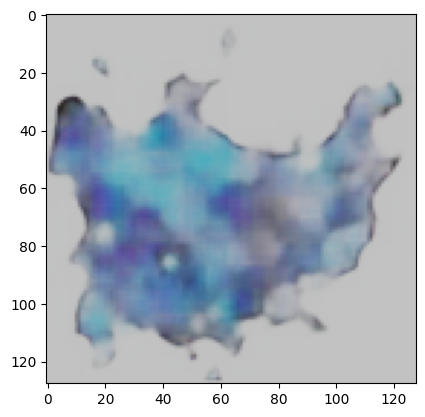

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import InputLayer, Lambda, Dense, Flatten,LeakyReLU


LATENT_DIM = 256
NOISE_DIM = 50
IMAGE_SIZE = 128

def sampling(args):
    z_mean, z_log_var = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = tf.keras.backend.random_normal(shape=(batch_size, LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def generator(decoder, noise_dim=NOISE_DIM):
    """
    Generate image from noise 
    Inputs:
    - decoder: pretrain model for genrate image freom mean and std
    - noise_dim: the dimension of the noise 
    
    Returns:
    TensorFlow Tensor with shape [number of image in one batch, 128, 128, 3]
    """

    # Freeze layers in the saved model
    for i, layer in enumerate(decoder.layers):
        layer.trainable = False
        layer._name = f'saved_model_{i}_{layer.name}'


    model = Sequential([
        tf.keras.Input(shape=noise_dim),
        tf.keras.layers.Reshape((noise_dim, 1)),
        tf.keras.layers.Conv1D(32, 3, activation = LeakyReLU()),
        tf.keras.layers.Conv1D(64, 3, activation=LeakyReLU()),
        tf.keras.layers.Conv1D(128, 3, activation=LeakyReLU()),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'),
        tf.keras.layers.Dropout(0.25),
        Flatten(),
        Dense(256, input_dim=noise_dim, activation=LeakyReLU()),
        Dense(512, activation=LeakyReLU()),
        #Dense(1024, activation=LeakyReLU())
        Lambda(lambda x: sampling([x[:, :256], x[:, 256:]]))
    ])
    
    # Add layers from the saved model
    for layer in decoder.layers:
        model.add(layer)

    # model.add(tf.keras.layers.Dense(...))
    # model.add(tf.keras.layers.ReLU(...))

    model.add(tf.keras.layers.Activation('tanh'))

    return model

generator_model = generator(decoder)
noise_example = np.random.rand(2, NOISE_DIM) # suppose 2 images in one batch
output_fake = generator_model(noise_example) # (2,49152) tensor

# Let's check the image
output_reshape = output_fake.numpy()#.reshape(-1,128,128,3)
plt.imshow(output_reshape[0])
plt.show()

In [ ]:
generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 50, 1)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 48, 32)            128       
                                                                 
 conv1d_4 (Conv1D)           (None, 46, 64)            6208      
                                                                 
 conv1d_5 (Conv1D)           (None, 44, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 128)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 43, 128)           0         
                                                      

In [ ]:
  # def discriminator():
  #     """Compute discriminator score for a batch of input images.
      
  #     Inputs:
  #     - x: tensor, shape [number of images in one batch, 49152 = 128 * 128 * 3]
    
  #     Returns:
  #     TensorFlow Tensor with shape [number of images in one batch, 1], containing the score 
  #     for an image being real for each input image.
  #     """

  #     model = tf.keras.models.Sequential([
  #         tf.keras.layers.InputLayer(IMAGE_SIZE * IMAGE_SIZE * 3),
  #         tf.keras.layers.Dense(10000),
  #         tf.keras.layers.LeakyReLU(0.1),        
  #         tf.keras.layers.Dense(3072),
  #         tf.keras.layers.LeakyReLU(0.1),
  #         tf.keras.layers.Dense(192),
  #         tf.keras.layers.LeakyReLU(0.1),
  #         tf.keras.layers.Dense(1, activation='sigmoid'),
  #     ])
  #     return model

  # discriminator_model = discriminator()

In [ ]:
def discriminator(input_shape=(128,128,3)):
  
    """Compute discriminator score for a batch of input images.
      
    Inputs:
    - x: tensor, shape [number of images in one batch, 128, 128, 3]
    
    Returns:
    TensorFlow Tensor with shape [number of images in one batch, 1], containing the score 
    for an image being real for each input image.
    """

    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Reshape((IMAGE_SIZE,IMAGE_SIZE,3), input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',input_shape = input_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

discriminator_model = discriminator()

In [ ]:
discriminator_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                      

In [ ]:
# Test discriminator for fake image
from keras.layers import Reshape
output_fake = tf.reshape(output_fake,(-1,128,128,3))

result_fake = discriminator_model(output_fake)
result_fake

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.49525094],
       [0.49476185]], dtype=float32)>

In [ ]:
# We get to real images, number of images in one batch = 2
output_real = x_data[:2]
output_real = tf.reshape(output_real,(-1,128,128,3))

# Test discriminator for real image
# Even output_real is np array, it convert to tensor automatically
result_real = discriminator_model(output_real)
result_real

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.49502966],
       [0.49443808]], dtype=float32)>

In [ ]:
# construct discriminator loss
def generator_loss(fake_score):
    target = tf.ones_like(fake_score) 
    loss = tf.keras.losses.BinaryCrossentropy(reduction='auto')(target,fake_score)
    return loss


def disciminator_loss(fake_score,real_score):
    target_real = tf.ones_like(real_score)
    loss_real = tf.keras.losses.BinaryCrossentropy(reduction='auto')(target_real,real_score)

    target_fake = tf.zeros_like(fake_score)
    loss_fake = tf.keras.losses.BinaryCrossentropy(reduction='auto')(target_fake,fake_score)

    return loss_real + loss_fake


In [ ]:
# Test the loss
loss = generator_loss(result_fake)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.7031847>

In [ ]:
loss = disciminator_loss(result_fake,result_real)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.3869451>

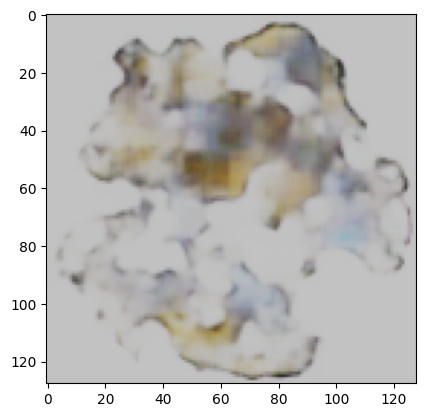

Epoch 1, Generator Loss: 14.745307922363281, fake score: 0.45068832584656776, Discriminator Loss: 28.596675872802734, real score: 0.5499809933826327


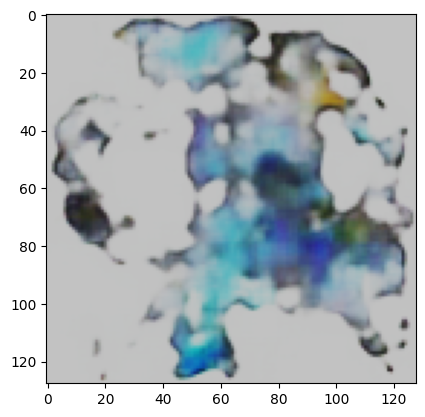

Epoch 2, Generator Loss: 4.649402141571045, fake score: 0.30597286894917486, Discriminator Loss: 2.930481433868408, real score: 0.7067774131894111


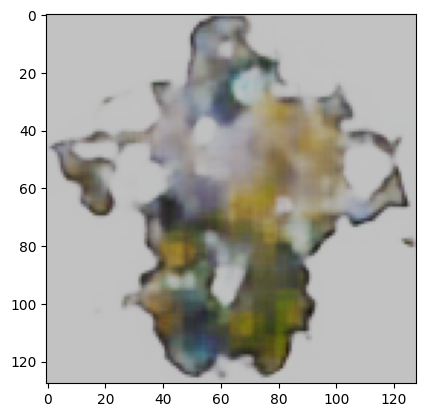

Epoch 3, Generator Loss: 3.247051239013672, fake score: 0.2559391146525741, Discriminator Loss: 1.2249680757522583, real score: 0.7636528506875038


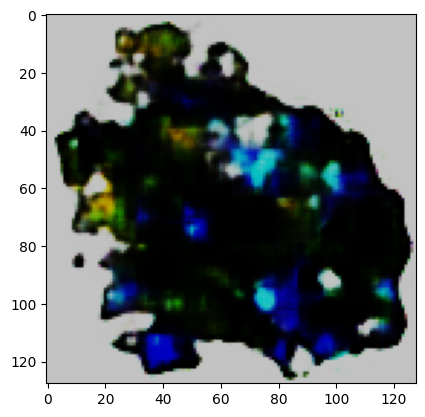

Epoch 4, Generator Loss: 2.628875255584717, fake score: 0.4229890383780003, Discriminator Loss: 3.4005351066589355, real score: 0.5418733157217502


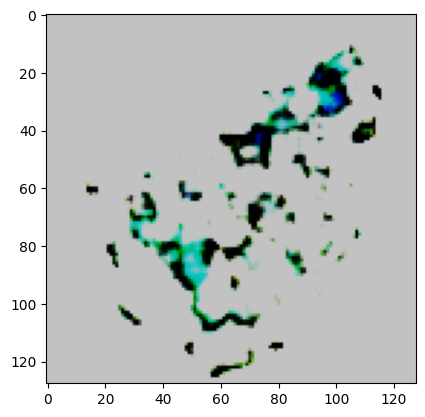

Epoch 5, Generator Loss: 3.694701671600342, fake score: 0.24295069128274918, Discriminator Loss: 1.5398677587509155, real score: 0.7395688593387604


In [ ]:
@tf.function
def train_step(real_images,generator_model,discriminator_model,generator_optimizor,discriminator_optimizor):
    """
    Input
    real_images: All images in one batch
    generator_model: generator model, we declear outside generator = generator()
    discriminator_model: discriminator model, we declear outside discriminator = discriminator()
    generator_optimizor: generator_optimizor for generator
    discriminator_optimizor: discriminator_optimizor for discriminator

    Returns:
    the distance between fake_score and all 0 [number of images in one batch, 1] tebsor by using BinaryCrossentropy
    +  the distance between real_score and all 1 [number of images in one batch, 1] tensor by using BinaryCrossentropy
    =  1 D tensor which contain the average batch loss value. Since we use reduction = 'sum_over_batch_size'
    """
    # real_images.shape[0] represent the number of images in one batch
    noise = tf.random.normal([real_images.shape[0], NOISE_DIM])

    # Observe from tensorflow document
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

      # generate images
      fake_images = generator_model(noise, training=True)

      # calculate the score of fake_images and real_images: [number of images in one batch, 1] tensor
      fake_score = discriminator_model(fake_images, training=True)
      real_score = discriminator_model(real_images, training=True)

      # calculate the loss
      generator_loss_value = generator_loss(fake_score)
      # print(generator_loss_value)
      disciminator_loss_value = disciminator_loss(fake_score,real_score)
    
    # Update the weights of the model to minimize the loss value.
    generator_gradients = gen_tape.gradient(generator_loss_value, generator_model.trainable_weights)
    disciminator_gradients = dis_tape.gradient(disciminator_loss_value, discriminator_model.trainable_weights)

    generator_optimizor.apply_gradients(zip(generator_gradients, generator_model.trainable_weights))
    discriminator_optimizor.apply_gradients(zip(disciminator_gradients, discriminator_model.trainable_weights))

    return generator_loss_value,disciminator_loss_value,fake_images,fake_score,real_score


def train_gan(dataset, generator, discriminator, epochs):
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(5e-3)

    for epoch in range(epochs):
        gen_loss_sum = 0
        disc_loss_sum = 0
        num_batches = 0
        fake_score_sum = 0
        real_score_sum = 0

        for image_batch in dataset:
            gen_loss, disc_loss,fake_images,fake_score,real_score = train_step(image_batch, generator, discriminator, generator_optimizer, discriminator_optimizer)
            gen_loss_sum += gen_loss
            disc_loss_sum += disc_loss
            num_batches += 1
            fake_score_sum += np.mean(fake_score.numpy())
            real_score_sum += np.mean(real_score.numpy())

        output_reshape = fake_images.numpy()
        plt.imshow(output_reshape[0])
        plt.show()

        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss_sum/num_batches}, fake score: {fake_score_sum/num_batches}, Discriminator Loss: {disc_loss_sum/num_batches}, real score: {real_score_sum/num_batches}')

generator_model = generator(decoder)
discriminator_model = discriminator()
train_gan(dataset, generator_model, discriminator_model, epochs=5)